In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.float = float
np.bool = bool
np.int = int
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import time
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import utils
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df_meta = pd.read_csv("/Users/labadmin/Projects/immusign/data/lymphoma-reps-file-infos.csv")
lymphoma_types = df_meta["lymphoma_specification"].unique()

In [3]:
df_meta.columns

Index(['pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'clones.txt.name', 'subject_id', 'sex',
       'dosc', 'age', 'dob'],
      dtype='object')

In [4]:
lymphoma_types

array(['cll', 'hd', 'unspecified', 'abc_dlbcl', 'nlphl', 'thrlbcl',
       'dlbcl', 'lymphadenitis', 'gcb_dlbcl'], dtype=object)

In [9]:
df_raw = utils.read_clones_txt(df_meta["clones.txt.name"].values, "/Users/labadmin/Projects/immusign/data/clones_mit_kidera")
df_raw["cloneFraction"] = df_raw["cloneFraction"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

  0%|          | 0/1394 [00:00<?, ?it/s]

In [51]:
df_raw.columns

Index(['cloneId', 'cloneCount', 'cloneFraction', 'nSeqCDR3', 'aaSeqCDR3',
       'bestVGene', 'bestDGene', 'bestJGene', 'vBestIdentityPercent',
       'lengthOfCDR3', 'targetSequences', 'allVGenes', 'allDGenes',
       'allJGenes', 'allVHits', 'allDHits', 'allJHits', 'allVAlignments',
       'allDAlignments', 'allJAlignments', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5',
       'KF6', 'KF7', 'KF8', 'KF9', 'KF10', 'clones.txt.name',
       'dBestIdentityPercent', 'jBestIdentityPercent', 'aaSeqCDR2',
       'aaSeqCDR1', 'aaSeqFR2', 'aaSeqFR3', 'aaSeqFR4',
       'aaSeqImputedVDJRegion'],
      dtype='object')

# Load Data read from R-Script

In [51]:
import rpy2.robjects as robjects
robjects.r['load']("/Users/labadmin/Projects/immusign/immusign_40000_reads_with_out_of_frame.RData")
twb = robjects.r['twb']

In [52]:
df = utils.convert_rtwb_to_pdtwb(twb)

In [53]:
df["clones.txt.name"] = df["sample"].apply(lambda x: x + ".clones.txt")

In [20]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name'],
      dtype='object')

# Add metric info

In [21]:
stats = pd.read_csv("/Users/labadmin/Projects/immusign/output/stats.csv", sep=";")
stats.rename(columns={stats.columns[0]:"sample"}, inplace=True)

In [22]:
df = df.merge(stats.iloc[:-2], on = "sample")

# Add meta info

In [23]:
df = df.merge(df_meta, on = "clones.txt.name")

In [24]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob'],
      dtype='object')

# Add correct clone Id before adding info from raw files

In [108]:
df["cloneId"] = None

for file in tqdm(df["clones.txt.name"].unique()):
    df_sub_file = df[df["clones.txt.name"] == file]
    df_raw_sub_file = df_raw[df_raw["clones.txt.name"] == file]
    for i, index_row in enumerate(df_sub_file.iterrows()):
        index, row = index_row[0], index_row[1]  
        if row["CDR3.nucleotide.sequence"] == df_raw_sub_file.iloc[i]["nSeqCDR3"]:
            df.loc[index,"cloneId"] = df_raw_sub_file.iloc[i]["cloneId"]

  0%|          | 0/679 [00:00<?, ?it/s]

In [116]:
df2 = df.merge(df_raw, left_on=["clones.txt.name", "cloneId", "CDR3.nucleotide.sequence"], right_on =["clones.txt.name", "cloneId", "nSeqCDR3"], how = "left")

In [55]:
df2.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [122]:
#df2.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data.pkl")

In [91]:
#df.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data_cleaned.pkl")

# Get rid of redundant information

In [76]:
#df = pd.read_pickle("immusign_40000_reads_with_out_of_frame_merged_raw_data.pkl")

### CDR3.amino.acid.sequence from R-scripts and aaSeqCDR3 from files not the same

In [ ]:
# test = df[~(df["CDR3.amino.acid.sequence"].apply(lambda x: x.replace("~", "_")) == df["aaSeqCDR3"])]

In [57]:
print(df["CDR3.amino.acid.sequence"].apply(lambda x: x.replace("~", "_")).loc[7])
print(df["aaSeqCDR3"].loc[7])

CASKSND_TGKGYW
CASKSN_TGKGYW


### bunch.translate function either drops 2 nucleotide (seq_len % 3 = 2) or repeats 2 nucleotides (seq_len % 2 = 1) leading to additional AS e.g. D in example above

In [77]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [90]:
df.drop(columns = ['Umi.count', 'Umi.proportion', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'nSeqCDR3'],inplace=True)

In [4]:
df["aaSeqCDR3"].unique()

array(['CARSPDHW', 'CARDVVVGYYYGMDVW', 'CASGYFEYSSSRPYGMDVW', ...,
       'CARAARQGSTGYYFFDYW', 'CARDLGRFSPPFCSGINCYEGGGFDPW',
       'CAREQEPYSNTDFW'], dtype=object)

In [5]:
df["Clonality"] = df["Clonality"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df["twb.shannon"] = df["twb.shannon"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df["twb.simp"] = df["twb.simp"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

In [6]:
df["age"] = df["age"].apply(lambda x: utils.tryconvert(x, np.nan, float))

In [7]:
np.sum(df["age"].isnull())

213328

In [8]:
np.sum(df["sex"].isnull())

209223

In [42]:
unkown_sex_id = df[df["sex"].isnull()]["subject_id"].unique()

In [43]:
df[df.subject_id.isin(unkown_sex)][~df[df.subject_id.isin(unkown_sex)]["sex"].isnull()][["sex", "subject_id"]].groupby(["sex", "subject_id"]).first()

Empty DataFrame
Columns: []
Index: [(female, CLL394), (female, HD096), (male, CLL300), (male, CLL374), (male, DLBCL07)]

In [54]:
df[df.subject_id == "CLL394"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "HD096"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "CLL300"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "CLL374"][["clones.txt.name", "sex", "subject_id"]]
df[df.subject_id == "DLBCL07"][["clones.txt.name", "sex", "subject_id"]]

,clones.txt.name,sex,subject_id
1195599,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195600,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195601,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195602,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
1195603,LisaS-hs-FR3-DLBCL07_S39.clones.txt,male,DLBCL07
...,...,...,...
1195690,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07
1195691,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07
1195692,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07
1195693,LisaS-hs-FR3-DLBCL07-II_S128.clones.txt,male,DLBCL07


In [53]:
df.loc[df.subject_id == "CLL394","sex"] = "female"
df.loc[df.subject_id == "HD096","sex"] = "female"
df.loc[df.subject_id == "CLL300","sex"] = "male"
df.loc[df.subject_id == "CLL374","sex"] = "male"
df.loc[df.subject_id == "DLBCL07","sex"] = "male"

In [55]:
np.sum(df["sex"].isnull())

207410

In [56]:
unkown_age_id = df[df["age"].isnull()]["subject_id"].unique()

In [58]:
df[df.subject_id.isin(unkown_age_id)][~df[df.subject_id.isin(unkown_age_id)]["age"].isnull()][["age", "subject_id"]].groupby(["age", "subject_id"]).first()

Empty DataFrame
Columns: []
Index: [(38.0, HD096), (52.0, HD020), (59.0, CLL367), (61.0, CLL144), (63.0, CLL300), (63.0, CLL368), (64.0, CLL144), (64.0, CLL368), (65.0, CLL306), (66.0, CLL144), (66.0, CLL306), (66.0, CLL374), (67.0, CLL306), (71.0, CLL353), (72.0, CLL353), (72.0, CLL394), (90.0, DLBCL07)]

In [65]:
df.loc[df.subject_id == "CLL368",["age", ]].unique()

array([63., 64., nan])

In [112]:
for idx, row in df[df["age"].isnull()].iterrows():
    if (not pd.isnull(row.dob)) and (not pd.isnull(row.dosc)):
        df.loc[idx, "age"] = utils.from_dosc_and_dob_to_age(row.dob, row.dosc)

In [114]:
unkown_age_id = df[df["age"].isnull()]["subject_id"].unique()

In [117]:
df[df.subject_id.isin(unkown_age_id)][~df[df.subject_id.isin(unkown_age_id)]["age"].isnull()][["age", "subject_id"]].groupby(["age", "subject_id"]).first()

Empty DataFrame
Columns: []
Index: [(38.0, HD096), (52.0, HD020), (61.0, CLL144), (63.0, CLL300), (64.0, CLL144), (66.0, CLL144), (66.0, CLL374), (72.0, CLL394), (90.0, DLBCL07)]

In [133]:
df.loc[df.subject_id == "HD096","age"] = 38
df.loc[df.subject_id == "HD020","age"] = 52
df.loc[df.subject_id == "CLL300","age"] = 63
df.loc[df.subject_id == "CLL374","age"] = 66
df.loc[df.subject_id == "CLL394","age"] = 72
df.loc[df.subject_id == "DLBCL07","age"] = 90
df.loc[(df.subject_id == "CLL144") & (df.age.isnull()),"age"] = 65

In [134]:
np.sum(df["age"].isnull())

196150

In [135]:
df["has_mutation"] = df["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)

In [136]:
#df.to_pickle("immusign/immusign_40000_reads_with_out_of_frame_merged_raw_data_cleaned.pkl")

# Small Analysis

In [2]:
df = pd.read_pickle("immusign/immusign_40000_reads_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [5]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

## Columns
cloneId --> Identified clones per sample <br>
cloneCount --> Absolute number found in sample <br>
cloneFraction --> Relative number found in sample (Attention: smaller than cloneCount/sum(cloneCount) because cut off < 2<br>
nSeqCDR3 --> Nucleotid sequence <br>
aaSeqCDR3 --> Amino Acid Sequence <br>
bestVGene --> best matching VGene <br>
bestDGene --> best matching DGene <br>
bestJGene --> best matching JGene <br>
vBestIdentityPercent --> Certainty of best matching VGene <br>
lengthOfCDR3 --> length of nucleotid sequence <br>
targetSequences --> Full sequence of nSeqCDR3 <br>
allVGenes --> All possible matches of V genes<br>
allDGenes --> All possible matches of D genes <br>
allJGenes --> All possible matches of J genes <br>
allVHits --> All V hits <br>
allDHits --> All D hits <br>
allJHits --> All J hits <br>
allVAlignments --> Alignments for each V hit <br>
allDAlignments --> Alignments for each D hit <br>
allJAlignments --> Alignments for each J hit <br>
KF1 - KF10 --> Kidera Factors <br>
clones.txt.name --> Sample file <br>
dBestIdentityPercent  --> Certainty of best matching DGene  <br>
jBestIdentityPercent  --> Certainty of best matching JGene  <br>
aaSeqCDR2 --> Amino Acid Sequence <br>
aaSeqCDR1 --> Amino Acid Sequence <br>
aaSeqFR2 --> Amino Acid Sequence  <br>
aaSeqFR3 --> Amino Acid Sequence  <br>
aaSeqFR4 --> Amino Acid Sequence <br>
aaSeqImputedVDJRegion --> Amino Acid Sequence <br>
<br>
--- META DATA ---<br>
pcr_target_locus --> Target Region of PCR ('IGH', 'TRB', 'IGHFR3', 'IGHFR2', 'TRBFR3') <br>
organism --> Organism of sample (hs) <br>
template --> DNA <br>
tissue --> Blood or Tissue['pb', 'tm'] <br>
lymphoma_type --> Identified lymphoma type <br>
lymphoma_specification --> dentified lymphoma type <br>
subject_id <br>
sex <br>
dosc --> date of sample collection <br>
age <br>
dob -->  date of birth<br>


# Distribution of data

<Axes: xlabel='lymphoma_specification', ylabel='Count'>

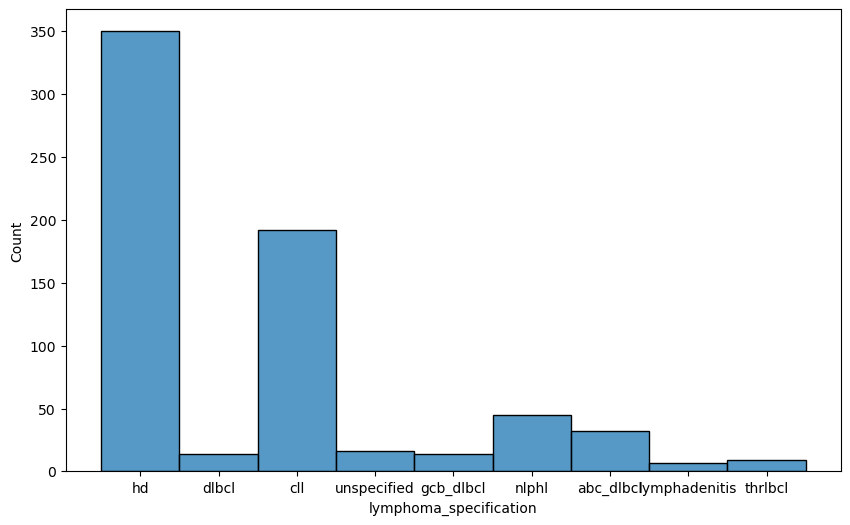

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df.groupby("clones.txt.name").first().reset_index()["lymphoma_specification"],ax = ax)

In [10]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

# Mutations in Data

In [11]:
df_mutations = df[df["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)]
mutations_per_group = df_mutations.groupby("lymphoma_specification").apply(len).reset_index()
total_per_group = df.groupby("lymphoma_specification").apply(len).reset_index()

In [12]:
total_per_group

,lymphoma_specification,0
0,abc_dlbcl,8846
1,cll,101752
2,dlbcl,8955
3,gcb_dlbcl,2498
4,hd,1162418
5,lymphadenitis,46484
6,nlphl,181327
7,thrlbcl,14480
8,unspecified,19853


In [13]:
mutations_per_group

,lymphoma_specification,0
0,abc_dlbcl,859
1,cll,15315
2,dlbcl,1204
3,gcb_dlbcl,314
4,hd,170284
5,lymphadenitis,4951
6,nlphl,20802
7,thrlbcl,1557
8,unspecified,2494


In [14]:
mutations_per_group[0]/total_per_group[0]

0    0.097106
1    0.150513
2    0.134450
3    0.125701
4    0.146491
5    0.106510
6    0.114721
7    0.107528
8    0.125623
Name: 0, dtype: float64

## % Mutations per Group

Text(0, 0.5, 'non-productive AA (%)')

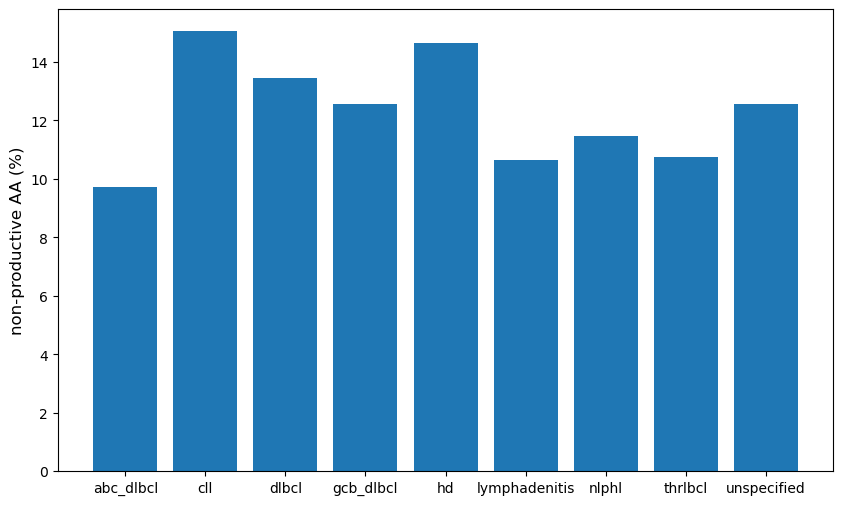

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mutations_per_group["lymphoma_specification"],mutations_per_group[0]/total_per_group[0] * 100)
ax.set_ylabel("non-productive AA (%)", size=12)

In [16]:
mutations_per_patient = df_mutations.groupby("clones.txt.name").apply(len).reset_index()
total_per_patient = df.groupby("clones.txt.name").apply(len).reset_index()

In [17]:
mutations_per_patient = mutations_per_patient.merge(total_per_patient, on="clones.txt.name",how="left")

In [18]:
mutations_per_patient = mutations_per_patient.merge(df_mutations[["clones.txt.name","lymphoma_specification"]], on="clones.txt.name", how="left")

In [29]:
mutations_per_patient["non-productive AA (%)"] = mutations_per_patient["0_x"]/mutations_per_patient["0_y"] * 100

In [20]:
mutations_per_patient.sort_values(by="lymphoma_specification", inplace = True)

## % Mutations per patient in groups

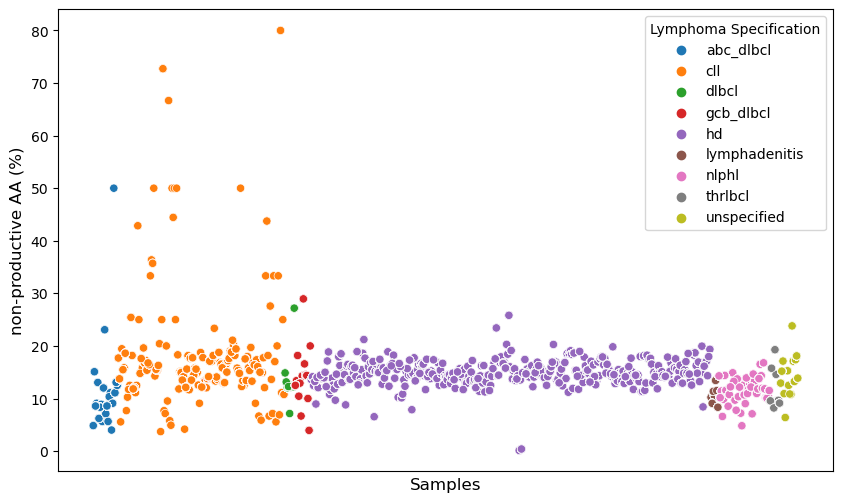

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='clones.txt.name', y='non-productive AA (%)', hue='lymphoma_specification', data=mutations_per_patient) 
ax.set_xticks([])
ax.set_ylabel("non-productive AA (%)", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

In [364]:
df[df["lymphoma_specification"] == "dlbcl"].age.isnull()

453878     True
453879     True
453880     True
453881     True
453882     True
           ... 
1388423    True
1388424    True
1388425    True
1388426    True
1388427    True
Name: age, Length: 8955, dtype: bool

In [374]:
df_age = df.groupby("clones.txt.name").first().reset_index()
age_per_group = df_age.groupby("lymphoma_specification")
age_per_group_median = age_per_group["age"].apply(np.nanmedian).reset_index()
print(age_per_group_median, "\n")

for key, group in age_per_group:
    print(key, sum(group["age"].isnull()), "%2.f %%" % (sum(group["age"].isnull())/len(group) * 100))

  lymphoma_specification   age
0              abc_dlbcl  71.0
1                    cll  66.0
2                  dlbcl   NaN
3              gcb_dlbcl   NaN
4                     hd  37.0
5          lymphadenitis  24.0
6                  nlphl  37.0
7                thrlbcl  40.0
8            unspecified  23.5 

abc_dlbcl 0  0 %
cll 37 19 %
dlbcl 14 100 %
gcb_dlbcl 14 100 %
hd 58 17 %
lymphadenitis 0  0 %
nlphl 2  4 %
thrlbcl 4 44 %
unspecified 14 88 %


All-NaN slice encountered


In [377]:
# for dlbcl, gcb_dlbcl set median to 71 (abc_dlbcl)
age_per_group_median.loc[age_per_group_median["lymphoma_specification"].isin(["dlbcl", "gcb_dlbcl"]), "age"] = 71.0

In [378]:
age_per_group_median

,lymphoma_specification,age
0,abc_dlbcl,71.0
1,cll,66.0
2,dlbcl,71.0
3,gcb_dlbcl,71.0
4,hd,37.0
5,lymphadenitis,24.0
6,nlphl,37.0
7,thrlbcl,40.0
8,unspecified,23.5


# Classification of Data

In [267]:
df = pd.read_pickle("immusign/immusign_40000_reads_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [137]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [512]:
# Shannon = 0 --> Eveness = 0 -- > Clonality = 1
df.loc[df["Clonality"].isnull(),"Clonality"] = 1.0

In [515]:
top_n_clones = 5

In [422]:
#df_age_above_60 = df[df.age > 60]

In [554]:
df_top_n = utils.get_top_n_clones(df, top_n_clones = top_n_clones)

In [517]:
df_top_n.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [590]:
feature_list = ["clones.txt.name", "cloneId", "lymphoma_specification", 'bestVGene', "has_mutation", 'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 'lengthOfCDR3', 'KF1', 'KF2',
       'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10']

X = df_top_n[feature_list].copy()

In [604]:
X_wide = utils.get_top_n_features_wide(df, ["lymphoma_specification"], ['bestVGene', "has_mutation", 'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 'lengthOfCDR3', 'KF1', 'KF2',
       'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'], top_n_clones=top_n_clones, keep_remaining_columns=False)

In [616]:
type(X_wide["bestVGene_1"].iloc[0]) == str

True

In [617]:
for column in X_wide.columns:
    if X_wide[column].dtype == float:
        if np.sum(X_wide[column].isnull()):
            X_wide[column] = X_wide[column].fillna(0)
    elif X_wide[column].dtype == object:
        if type(X_wide[column].iloc[0]) == bool:
            if np.sum(X_wide[column].isnull()):
                X_wide[column] = X_wide[column].fillna(False)
        elif type(X_wide[column].iloc[0]) == str:
            if np.sum(X_wide[column].isnull()):
                X_wide[column] = X_wide[column].fillna("nan")

In [618]:
for column in X_wide.columns:
    print(column + " :", "%.2f %%" % (X_wide[column].isnull().sum()/len(X_wide)*100), X_wide[column].dtype)

Read.proportion_1 : 0.00 % float64
Read.proportion_2 : 0.00 % float64
Read.proportion_3 : 0.00 % float64
Read.proportion_4 : 0.00 % float64
Read.proportion_5 : 0.00 % float64
clones.txt.name : 0.00 % object
Clonality_1 : 0.00 % float64
Clonality_2 : 0.00 % float64
Clonality_3 : 0.00 % float64
Clonality_4 : 0.00 % float64
Clonality_5 : 0.00 % float64
twb.shannon_1 : 0.00 % float64
twb.shannon_2 : 0.00 % float64
twb.shannon_3 : 0.00 % float64
twb.shannon_4 : 0.00 % float64
twb.shannon_5 : 0.00 % float64
twb.simp_1 : 0.00 % float64
twb.simp_2 : 0.00 % float64
twb.simp_3 : 0.00 % float64
twb.simp_4 : 0.00 % float64
twb.simp_5 : 0.00 % float64
lymphoma_specification : 0.00 % object
bestVGene_1 : 0.00 % object
bestVGene_2 : 0.00 % object
bestVGene_3 : 0.00 % object
bestVGene_4 : 0.00 % object
bestVGene_5 : 0.00 % object
lengthOfCDR3_1 : 0.00 % float64
lengthOfCDR3_2 : 0.00 % float64
lengthOfCDR3_3 : 0.00 % float64
lengthOfCDR3_4 : 0.00 % float64
lengthOfCDR3_5 : 0.00 % float64
KF1_1 : 0.00 %

## Get info about nan values

In [480]:
for column in X.columns:
    print(column + " :", "%.2f %%" % (X[column].isnull().sum()/len(X)*100), X[column].dtype)

clones.txt.name : 0.00 % object
cloneId : 0.00 % object
lymphoma_specification : 0.00 % object
bestVGene : 0.00 % object
has_mutation : 0.00 % bool
Read.proportion : 0.00 % float64
Clonality : 0.07 % float64
twb.shannon : 0.00 % float64
twb.simp : 0.00 % float64
lengthOfCDR3 : 0.00 % int64
KF1 : 0.00 % float64
KF2 : 0.00 % float64
KF3 : 0.00 % float64
KF4 : 0.00 % float64
KF5 : 0.00 % float64
KF6 : 0.00 % float64
KF7 : 0.00 % float64
KF8 : 0.00 % float64
KF9 : 0.00 % float64
KF10 : 0.00 % float64


## Sex and Age as predictor 
- can be important but in our case should be balanced (e.g. undpsecified and hd younger)
- for df_age_above_60 age less important role 

In [373]:
#X["sex"] = X["sex"].fillna(X['sex'].value_counts().index[0])

In [387]:
# fill age with group median: 

#for i,row in age_per_group_median.iterrows():
#    X.loc[(X["lymphoma_specification"] == row.lymphoma_specification) & (X["age"].isnull()), "age"] = row.age

In [28]:
#X.dropna(axis=0, inplace = True)

In [122]:
#X = X[~(X["lymphoma_specification"] == 'unspecified')]

## Wide Dataframe

In [619]:
X = X_wide.copy()

In [620]:
def custom_combiner(feature, category):
    return str(feature) + "_" + str(category)

In [621]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

categorical_preprocessor = OneHotEncoder(handle_unknown = 'ignore',feature_name_combiner=custom_combiner, sparse_output=False)
numerical_preprocessor = StandardScaler()
target_preprocessor = LabelEncoder()

In [622]:
Y_target = target_preprocessor.fit_transform(X["lymphoma_specification"])

In [624]:
np.unique(Y_target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [623]:
labels = []
for i in range(len(X["lymphoma_specification"].unique())):
    labels.append(np.asarray(X["lymphoma_specification"])[Y_target==i][0])

In [625]:
labels

['abc_dlbcl',
 'cll',
 'dlbcl',
 'gcb_dlbcl',
 'hd',
 'lymphadenitis',
 'nlphl',
 'thrlbcl',
 'unspecified']

In [626]:
X.insert(loc=0, column = "lymphoma_specification_encoded", value=Y_target)

In [489]:
X.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name', 'cloneId',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [545]:
X.columns

Index(['lymphoma_specification_encoded', 'Read.proportion_1',
       'Read.proportion_2', 'Read.proportion_3', 'Read.proportion_4',
       'Read.proportion_5', 'clones.txt.name', 'Clonality_1', 'Clonality_2',
       'Clonality_3', 'Clonality_4', 'Clonality_5', 'twb.shannon_1',
       'twb.shannon_2', 'twb.shannon_3', 'twb.shannon_4', 'twb.shannon_5',
       'twb.simp_1', 'twb.simp_2', 'twb.simp_3', 'twb.simp_4', 'twb.simp_5',
       'lymphoma_specification', 'bestVGene_1', 'bestVGene_2', 'bestVGene_3',
       'bestVGene_4', 'bestVGene_5', 'lengthOfCDR3_1', 'lengthOfCDR3_2',
       'lengthOfCDR3_3', 'lengthOfCDR3_4', 'lengthOfCDR3_5', 'KF1_1', 'KF1_2',
       'KF1_3', 'KF1_4', 'KF1_5', 'KF2_1', 'KF2_2', 'KF2_3', 'KF2_4', 'KF2_5',
       'KF3_1', 'KF3_2', 'KF3_3', 'KF3_4', 'KF3_5', 'KF4_1', 'KF4_2', 'KF4_3',
       'KF4_4', 'KF4_5', 'KF5_1', 'KF5_2', 'KF5_3', 'KF5_4', 'KF5_5', 'KF6_1',
       'KF6_2', 'KF6_3', 'KF6_4', 'KF6_5', 'KF7_1', 'KF7_2', 'KF7_3', 'KF7_4',
       'KF7_5', 'KF8_1',

In [567]:
print(X.columns)

Index(['lymphoma_specification_encoded', 'Read.proportion_1',
       'Read.proportion_2', 'Read.proportion_3', 'Read.proportion_4',
       'Read.proportion_5', 'clones.txt.name', 'Clonality_1', 'Clonality_2',
       'Clonality_3', 'Clonality_4', 'Clonality_5', 'twb.shannon_1',
       'twb.shannon_2', 'twb.shannon_3', 'twb.shannon_4', 'twb.shannon_5',
       'twb.simp_1', 'twb.simp_2', 'twb.simp_3', 'twb.simp_4', 'twb.simp_5',
       'lymphoma_specification', 'bestVGene_1', 'bestVGene_2', 'bestVGene_3',
       'bestVGene_4', 'bestVGene_5', 'lengthOfCDR3_1', 'lengthOfCDR3_2',
       'lengthOfCDR3_3', 'lengthOfCDR3_4', 'lengthOfCDR3_5', 'KF1_1', 'KF1_2',
       'KF1_3', 'KF1_4', 'KF1_5', 'KF2_1', 'KF2_2', 'KF2_3', 'KF2_4', 'KF2_5',
       'KF3_1', 'KF3_2', 'KF3_3', 'KF3_4', 'KF3_5', 'KF4_1', 'KF4_2', 'KF4_3',
       'KF4_4', 'KF4_5', 'KF5_1', 'KF5_2', 'KF5_3', 'KF5_4', 'KF5_5', 'KF6_1',
       'KF6_2', 'KF6_3', 'KF6_4', 'KF6_5', 'KF7_1', 'KF7_2', 'KF7_3', 'KF7_4',
       'KF7_5', 'KF8_1',

In [627]:
columns = list(X.columns)
features = columns
for x in ["lymphoma_specification_encoded", "clones.txt.name", "lymphoma_specification"]:
    features.remove(x)
    
categorical = ['bestVGene_1', 'bestVGene_2', 'bestVGene_3',
       'bestVGene_4', 'bestVGene_5', 'has_mutation_1', 'has_mutation_2', 'has_mutation_3',
       'has_mutation_4', 'has_mutation_5']

numerical = features
for x in categorical:
    numerical.remove(x)

In [628]:
transformed_categories = categorical_preprocessor.fit_transform(X[categorical])
transformed_categories = pd.DataFrame(data = transformed_categories, columns=categorical_preprocessor.get_feature_names_out())

X = pd.concat([X.reset_index(drop=True), transformed_categories], axis=1) 

In [492]:
X.columns[19:21]

Index(['KF9', 'KF10'], dtype='object')

## a) Random Splitting in Training and Test

In [312]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_target, random_state=42
)

## b) Patientwise Splitting

In [437]:
test_clones = np.asarray(X.groupby(["lymphoma_specification","clones.txt.name"]).size().reset_index().groupby("lymphoma_specification").sample(frac=0.25, random_state=42)["clones.txt.name"])

In [78]:
X_test = X[X["clones.txt.name"].isin(test_clones)]
y_test = np.asarray(X_test["lymphoma_specification_encoded"])

In [79]:
X_train = X[~X["clones.txt.name"].isin(test_clones)]
y_train = np.asarray(X_train["lymphoma_specification_encoded"])

In [70]:
print(len(test))
print(len(train))

389763
1156842


In [71]:
X_train.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [80]:
X_train.iloc[:, 5:] = numerical_preprocessor.fit_transform(X_train.iloc[:, 5:])
X_test.iloc[:, 5:] = numerical_preprocessor.transform(X_test.iloc[:, 5:])

In [81]:
transformed_categories_train = categorical_preprocessor.fit_transform(X_train.iloc[:,3:5])
transformed_categories_test = categorical_preprocessor.transform(X_test.iloc[:,3:5])

In [82]:
transformed_categories_train = pd.DataFrame(data = transformed_categories_train, columns=categorical_preprocessor.get_feature_names_out())
transformed_categories_test = pd.DataFrame(data = transformed_categories_test, columns=categorical_preprocessor.get_feature_names_out())

In [83]:
X_train = pd.concat([X_train.reset_index(drop=True), transformed_categories_train], axis=1) 
X_test = pd.concat([X_test.reset_index(drop=True), transformed_categories_test], axis=1) 

In [84]:
X_train.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3',
       ...
       'bestVGene_TRBV7-3', 'bestVGene_TRBV7-4', 'bestVGene_TRBV7-5',
       'bestVGene_TRBV7-6', 'bestVGene_TRBV7-7', 'bestVGene_TRBV7-8',
       'bestVGene_TRBV7-9', 'bestVGene_TRBV9', 'has_mutation_False',
       'has_mutation_True'],
      dtype='object', length=164)

## c) Groupwise K-Fold Cross Validation

In [629]:
lymphoma_fold_dict,  train_fold_patients, test_fold_patients = utils.grouped_patientwise_k_folds(X, "lymphoma_specification", "clones.txt.name")

In [494]:
X.columns[6:21]

Index(['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [630]:
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []

for i, train_fold in enumerate(tqdm(train_fold_patients)):
    test_fold = test_fold_patients[i]
    X_test = X[X["clones.txt.name"].isin(test_fold)]
    y_test = np.asarray(X_test["lymphoma_specification_encoded"])

    X_train = X[X["clones.txt.name"].isin(train_fold)]
    y_train = np.asarray(X_train["lymphoma_specification_encoded"])

    X_train.loc[:, numerical] = numerical_preprocessor.fit_transform(X_train.loc[:, numerical])
    X_test.loc[:, numerical] = numerical_preprocessor.transform(X_test.loc[:, numerical])

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)

    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [631]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [632]:
sampling_strategies = {
    'None': None,
    'adasyn': ADASYN(random_state=42),
    'random_over': RandomOverSampler(random_state=42),
    'smote': SMOTE(random_state=42),
    'random_under' : RandomUnderSampler(random_state=42)
}

# ADASYN improved version of smote (KNN) synthetic data
# Under sampling --> loose data 
# Over sampling --> see datapoints multiple times generalization?

In [650]:
sampler = sampling_strategies["random_over"]

# Simple Logistic Regression

In [172]:
from sklearn.linear_model import LogisticRegression

In [320]:
fold_preds_reg = []
shap_values_reg = []
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.iloc[:,14:], y_train)
    
    model_reg_i = LogisticRegression(max_iter = 500)
    model_reg_i.fit(X_train, y_train)

    y_pred = model_reg_i.predict(X_test.iloc[:,14:])
    fold_preds_reg.append(y_pred)

    # Fits the explainer
    #explainer = shap.Explainer(model_reg_i.predict, X_test.iloc[:,7:])
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,7:])
    #shap_values_reg.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

In [158]:
classification_reports_reg = []
for i, y_pred in enumerate(tqdm(fold_preds_reg)):
    classification_reports_reg.append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(labels),output_dict=True))

average_classification_report_reg = utils.get_averaged_classification_report(classification_reports_reg)
print(average_classification_report_reg)

  0%|          | 0/5 [00:00<?, ?it/s]

               precision    recall  f1-score   support

    abc_dlbcl       0.36      0.52      0.41     89.20
          cll       0.60      0.46      0.52    549.80
        dlbcl       0.07      0.23      0.11     42.40
    gcb_dlbcl       0.24      0.46      0.31     52.00
           hd       0.92      0.59      0.72   1400.00
lymphadenitis       0.16      0.57      0.23     28.00
        nlphl       0.41      0.48      0.44    180.00
      thrlbcl       0.04      0.27      0.08     36.00
  unspecified       0.15      0.54      0.24     64.00

     accuracy                           0.53   2441.40
    macro avg       0.33      0.46      0.34   2441.40
 weighted avg       0.72      0.53      0.60   2441.40



  0%|          | 0/5 [00:00<?, ?it/s]

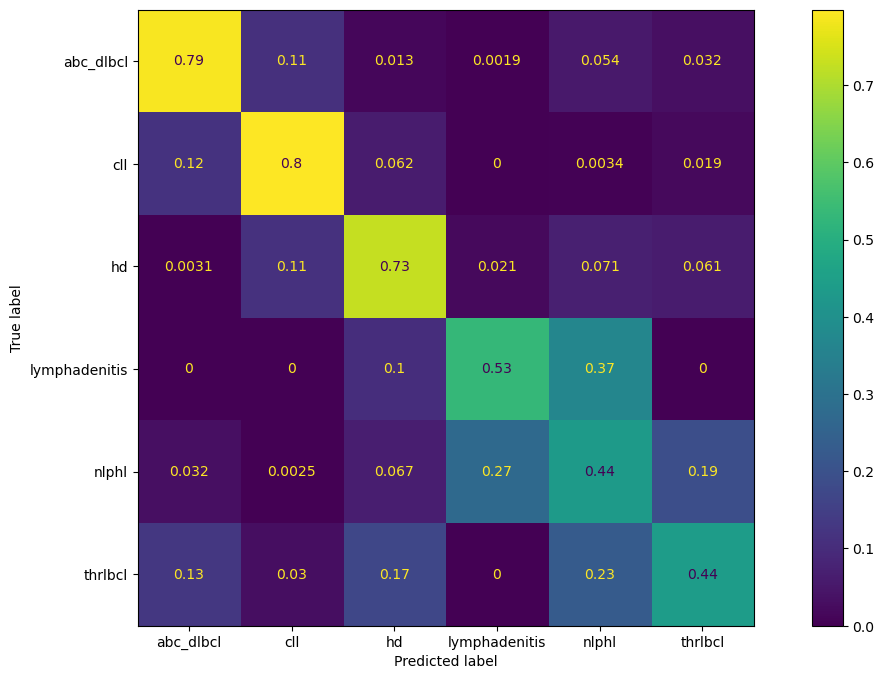

In [252]:
cms = []
for i, y_pred in enumerate(tqdm(fold_preds_reg)):
    cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
    cms.append(cm)
cms = np.asarray(cms)

fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels)
disp.plot(ax=ax)

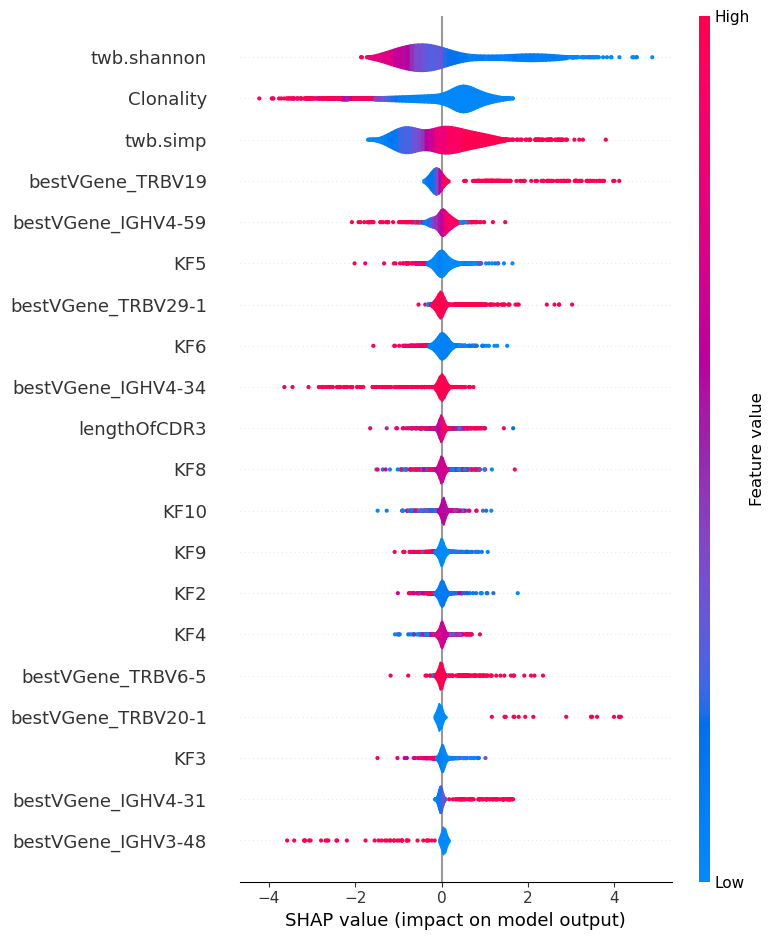

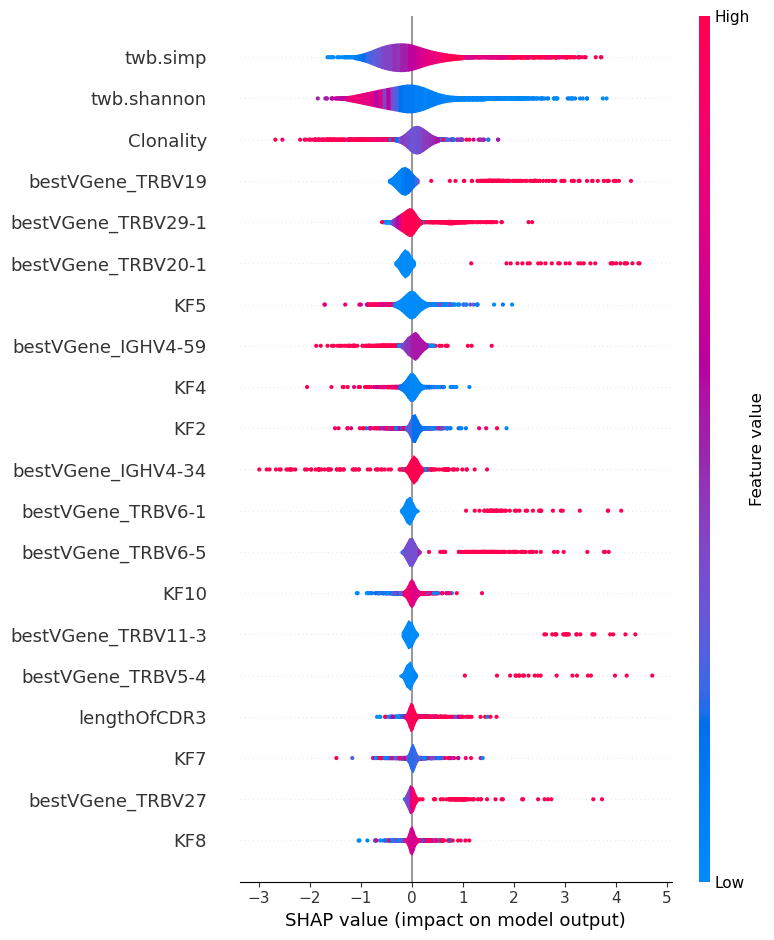

In [169]:
shap.summary_plot(shap_values_reg[0], plot_type='violin')
shap.summary_plot(shap_values_reg[1], plot_type='violin')

In [253]:
coefficients = model_reg_i.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)

In [172]:
X_train.columns

Index(['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5',
       ...
       'bestVGene_TRBV7-2', 'bestVGene_TRBV7-3', 'bestVGene_TRBV7-4',
       'bestVGene_TRBV7-5', 'bestVGene_TRBV7-6', 'bestVGene_TRBV7-7',
       'bestVGene_TRBV7-9', 'bestVGene_TRBV9', 'has_mutation_False',
       'has_mutation_True'],
      dtype='object', length=127)

<Axes: ylabel='Feature'>

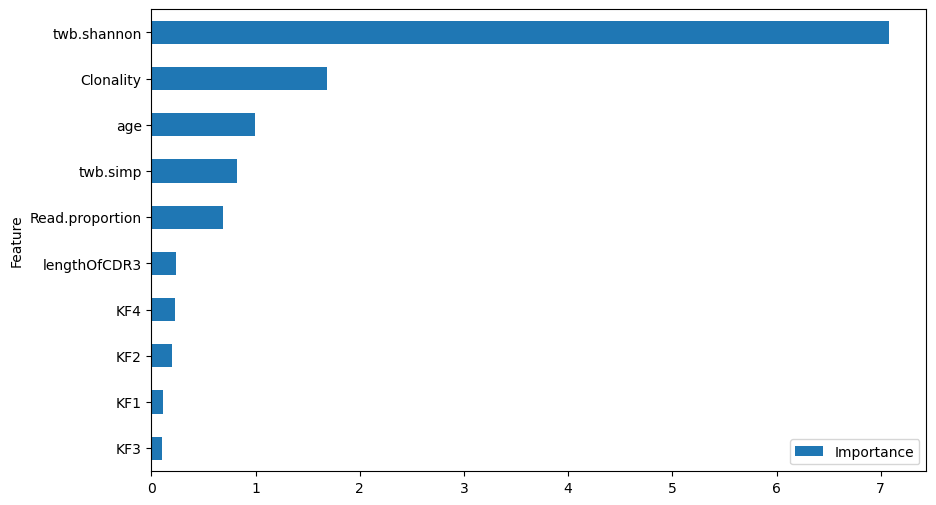

In [254]:
feature_importance = pd.DataFrame({'Feature': X_train.columns[:10], 'Importance': avg_importance[0:10]})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

# SVM with RBF Kernel

In [123]:
from sklearn.svm import SVC

In [125]:
fold_preds_svm = []
shap_values_svm = []
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    #X_train, y_train = sampler.fit_resample(X_train.iloc[:,7:], y_train)
    
    model_svm_i = SVC(kernel='rbf', max_iter=500)
    model_svm_i.fit(X_train.iloc[:,14:], y_train)

    y_pred = model_svm_i.predict(X_test.iloc[:,14:])
    fold_preds_svm.append(y_pred)

    # Fits the explainer
    #explainer = shap.Explainer(model_svm_i.predict, X_test.iloc[:,6:])
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,6:])
    #shap_values_svm.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

In [179]:
classification_reports_svm = []
for i, y_pred in enumerate(tqdm(fold_preds_svm)):
    classification_reports_svm.append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(labels),output_dict=True))

average_classification_report_svm = utils.get_averaged_classification_report(classification_reports_svm)
print(average_classification_report_svm)

  0%|          | 0/5 [00:00<?, ?it/s]

               precision    recall  f1-score   support

    abc_dlbcl       0.32      0.37      0.34     89.20
          cll       0.59      0.46      0.51    549.80
        dlbcl       0.11      0.14      0.11     42.40
    gcb_dlbcl       0.22      0.32      0.26     52.00
           hd       0.85      0.70      0.77   1400.00
lymphadenitis       0.14      0.21      0.16     28.00
        nlphl       0.44      0.67      0.52    180.00
      thrlbcl       0.06      0.20      0.08     36.00
  unspecified       0.18      0.49      0.26     64.00

     accuracy                           0.60   2441.40
    macro avg       0.32      0.40      0.34   2441.40
 weighted avg       0.68      0.60      0.62   2441.40



  0%|          | 0/5 [00:00<?, ?it/s]

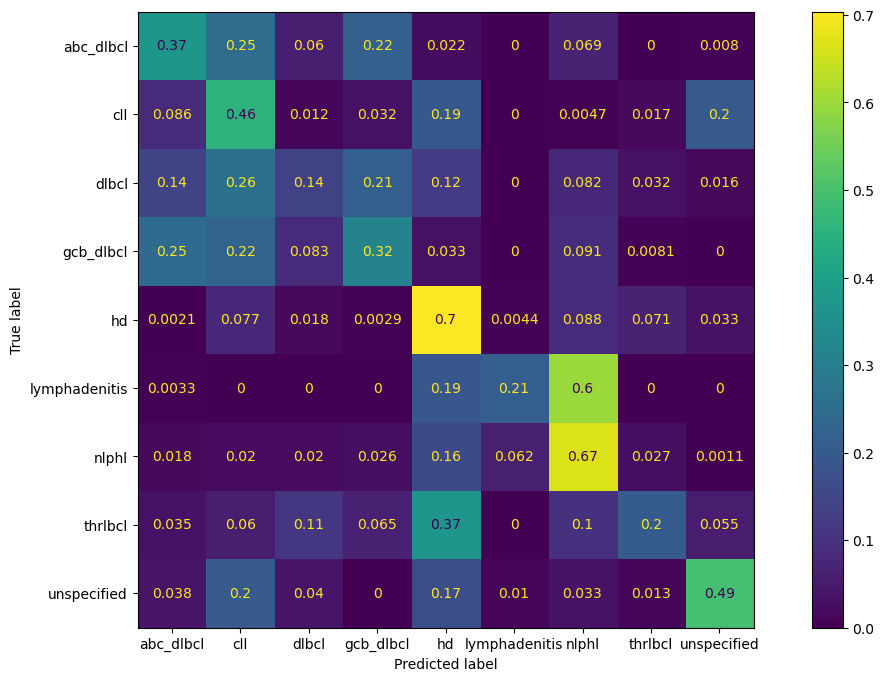

In [180]:
cms = []
for i, y_pred in enumerate(tqdm(fold_preds_svm)):
    cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
    cms.append(cm)
cms = np.asarray(cms)

fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels)
disp.plot(ax=ax)

# Random Forrest

In [651]:
from sklearn.ensemble import RandomForestClassifier

In [652]:
features_fit = list(X.columns)
for x in (categorical + ["lymphoma_specification_encoded", "clones.txt.name", "lymphoma_specification"]):
    features_fit.remove(x)

In [653]:
fold_preds_tree = []
shap_values_tree = []
coefficients_tree = []
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.loc[:,features_fit], y_train)
    
    model_tree_i = RandomForestClassifier(random_state=42)
    model_tree_i.fit(X_train, y_train)

    y_pred = model_tree_i.predict(X_test.loc[:,features_fit])
    fold_preds_tree.append(y_pred)

    coefficients_tree.append(model_tree_i.feature_importances_)
    # Fits the explainer
    #explainer = shap.TreeExplainer(model_tree_i)
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,7:])
    #shap_values_tree.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

In [654]:
classification_reports_tree = []
for i, y_pred in enumerate(tqdm(fold_preds_tree)):
    target_names_in_targets = np.unique(y_test_folds[i])
    target_names = [labels[i] for i in target_names_in_targets]
    classification_reports_tree.append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(target_names),output_dict=True))

average_classification_report_tree = utils.get_averaged_classification_report(classification_reports_tree)
print(average_classification_report_tree)
#print(utils.get_averaged_classification_report(classification_reports_tree[-1:]))

  0%|          | 0/5 [00:00<?, ?it/s]

               precision    recall  f1-score   support

    abc_dlbcl       0.33      0.10      0.14      6.40
          cll       0.65      0.85      0.73     38.40
        dlbcl       0.80      0.30      0.43      2.80
    gcb_dlbcl       0.60      0.20      0.30      2.80
           hd       0.82      0.90      0.86     70.00
lymphadenitis       0.00      0.00      0.00      1.40
        nlphl       0.69      0.31      0.43      9.00
      thrlbcl       0.00      0.00      0.00      1.80
  unspecified       0.40      0.12      0.18      3.20

     accuracy                           0.75    135.80
    macro avg       0.48      0.31      0.34    135.80
 weighted avg       0.71      0.75      0.70    135.80



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

  0%|          | 0/5 [00:00<?, ?it/s]

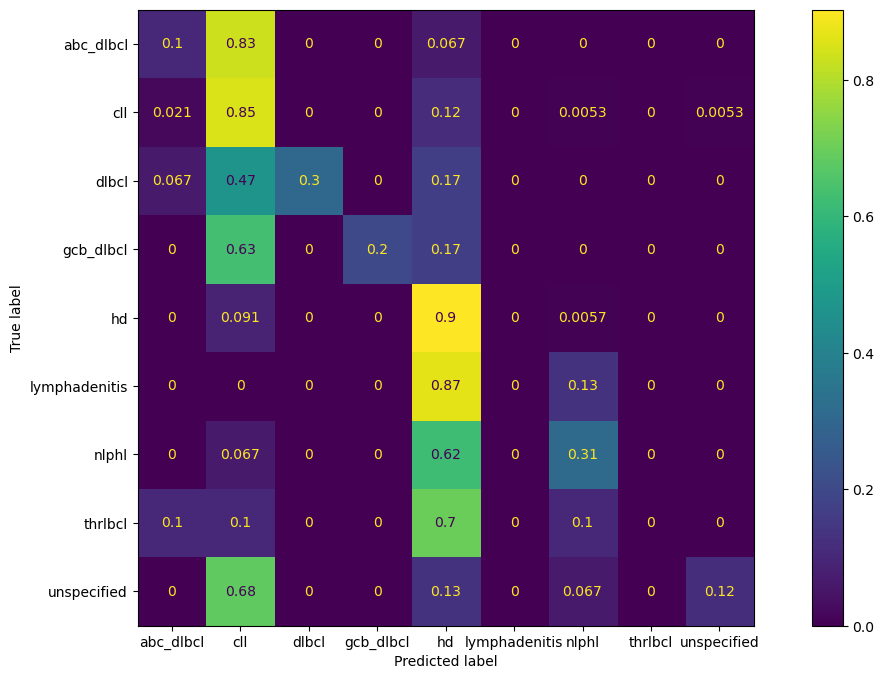

In [655]:
cms = []
for i, y_pred in enumerate(tqdm(fold_preds_tree)):
    cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
    cms.append(cm)
cms = np.asarray(cms)

fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels)
disp.plot(ax=ax)

In [646]:
coefficients = np.mean(np.asarray(coefficients_tree), axis=0)

In [647]:
palette = sns.color_palette(palette='Blues')

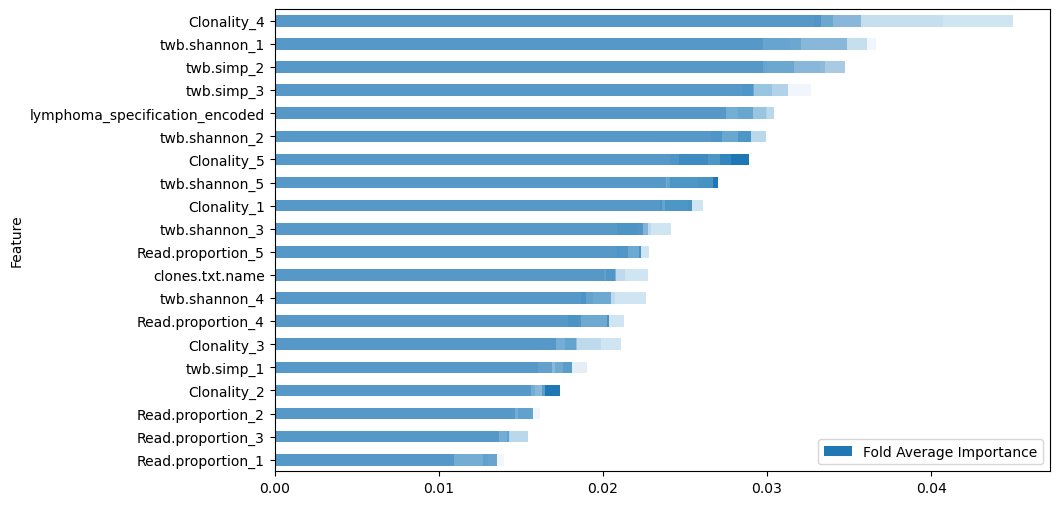

In [648]:
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance = pd.DataFrame({'Feature': X_train.columns[:20], 'Importance': coefficients[0:20]})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', ax=ax, label = "Fold Average Importance")

for i, cof in enumerate(coefficients_tree):
    feature_importance_i = pd.DataFrame({'Feature': X_train.columns[:20], 'Importance': cof[0:20]})
    feature_importance_i = feature_importance_i.sort_values('Importance', ascending=True)
    feature_importance_i.plot(x='Feature', y='Importance', kind='barh', ax=ax, color =palette[i], alpha=0.4, label="", legend=False)

#feature_importance = pd.DataFrame({'Feature': X_train.columns[:10], 'Importance': coefficients[0:10]})
#feature_importance = feature_importance.sort_values('Importance', ascending=True)
#feature_importance.plot(x='Feature', y='Importance', kind='barh',alpha=0.0 , hatch = "/", ax=ax , legend = False)

# CatBoost

In [148]:
from catboost import CatBoostClassifier 

In [149]:
fold_preds_cat = []
shap_values_cat = []
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.iloc[:,6:], y_train)
    
    model_cat = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    model_cat.fit(X_train, y_train)

    y_pred = model_cat.predict(X_test.iloc[:,6:])
    fold_preds_cat.append(y_pred)

    # Fits the explainer
    #explainer = shap.TreeExplainer(model_tree_i)
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,6:])
    #shap_values_tree.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

In [150]:
classification_reports_cat = []
for i, y_pred in enumerate(tqdm(fold_preds_cat)):
    classification_reports_cat.append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(labels),output_dict=True))

average_classification_report_cat = utils.get_averaged_classification_report(classification_reports_cat)
print(average_classification_report_cat)

  0%|          | 0/5 [00:00<?, ?it/s]

               precision    recall  f1-score   support

    abc_dlbcl       0.62      0.60      0.60     89.80
          cll       0.75      0.83      0.79    550.80
        dlbcl       0.27      0.29      0.27     42.40
    gcb_dlbcl       0.49      0.63      0.54     52.00
           hd       0.91      0.87      0.89   1400.00
lymphadenitis       0.34      0.33      0.29     28.00
        nlphl       0.65      0.68      0.66    180.00
      thrlbcl       0.20      0.24      0.20     36.00

     accuracy                           0.80   2379.00
    macro avg       0.53      0.56      0.53   2379.00
 weighted avg       0.81      0.80      0.80   2379.00



  0%|          | 0/5 [00:00<?, ?it/s]

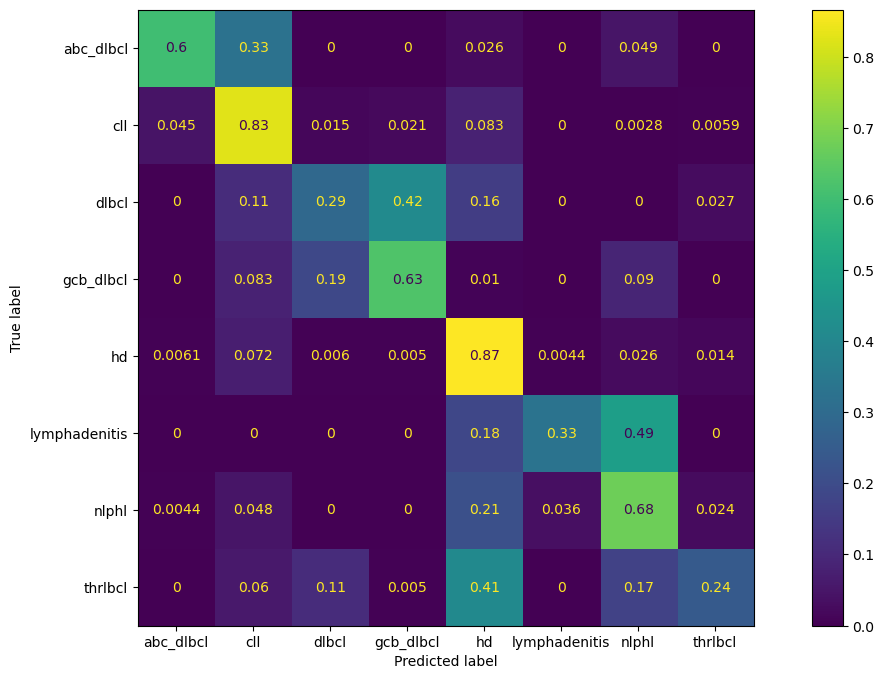

In [151]:
cms = []
for i, y_pred in enumerate(tqdm(fold_preds_cat)):
    cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
    cms.append(cm)
cms = np.asarray(cms)

fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels)
disp.plot(ax=ax)

In [407]:
labels_grouped = ["abc_dlbcl, dlbcl, gcb_dlbcl, thrlbcl", "cll", "hd", "lymphadenitis", "nlphl", "unspecified"]

In [402]:
grouped_label_mapping = {0:0, 1:1, 2:0, 3:0, 4:2, 5:3, 6:4, 7:0, 8:5}

In [406]:
y_test_folds_grouped = []
fold_preds_cat_grouped = []

for i, test_fold in enumerate(tqdm(y_test_folds)):
    y_test_folds_grouped.append([grouped_label_mapping[x] for x in test_fold])
    fold_preds_cat_grouped.append([grouped_label_mapping[x[0]] for x in fold_preds_cat[i]])

  0%|          | 0/5 [00:00<?, ?it/s]

In [410]:
classification_reports_cat_grouped = []
for i, y_pred in enumerate(tqdm(fold_preds_cat_grouped)):
    classification_reports_cat_grouped.append(classification_report(y_test_folds_grouped[i], y_pred, target_names=np.asarray(labels_grouped),output_dict=True))


average_classification_report_cat_grouped = utils.get_averaged_classification_report(classification_reports_cat_grouped)
print(average_classification_report_cat_grouped)

  0%|          | 0/5 [00:00<?, ?it/s]

                                      precision    recall  f1-score   support

abc_dlbcl, dlbcl, gcb_dlbcl, thrlbcl       0.28      0.27      0.26   6955.20
                                 cll       0.43      0.49      0.45  20349.40
                                  hd       0.87      0.87      0.87 232483.60
                       lymphadenitis       0.01      0.02      0.01   9296.80
                               nlphl       0.56      0.56      0.56  36265.40
                         unspecified       0.24      0.09      0.12   3970.60

                            accuracy                           0.76 309321.00
                           macro avg       0.40      0.38      0.38 309321.00
                        weighted avg       0.76      0.76      0.76 309321.00



  0%|          | 0/5 [00:00<?, ?it/s]

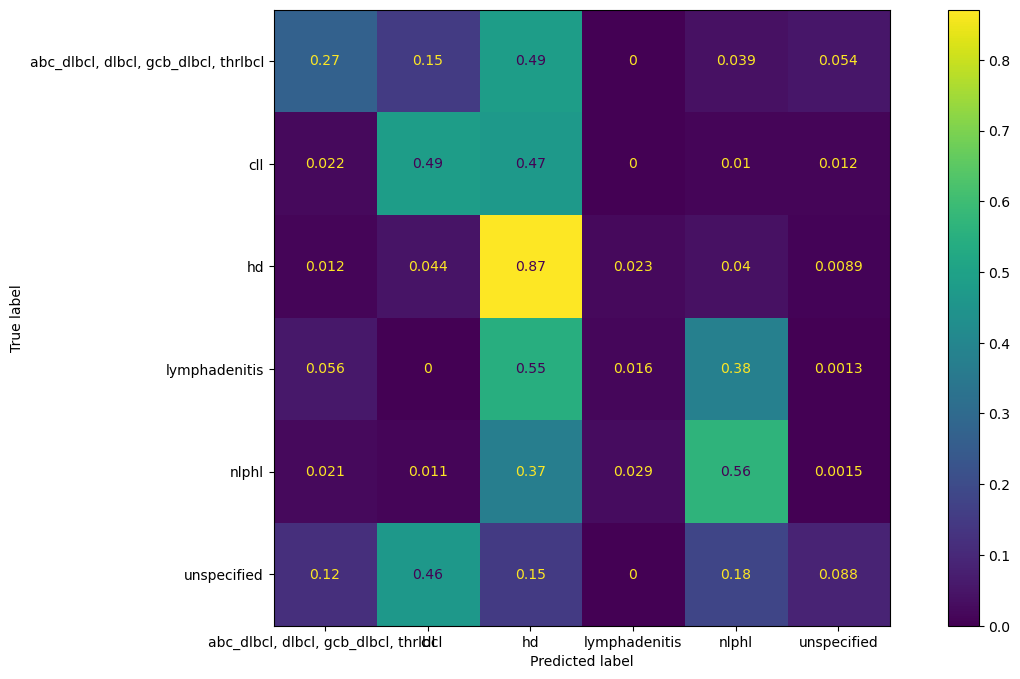

In [411]:
cms = []
for i, y_pred in enumerate(tqdm(fold_preds_cat_grouped)):  
    cm = confusion_matrix(y_test_folds_grouped[i], y_pred, normalize="true") # normalize over true values
    cms.append(cm)
cms = np.asarray(cms)
fig, ax = plt.subplots(figsize = (15,8))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels_grouped)
disp.plot(ax=ax)

# Ideas
- add other information sex age
- combine to one vector --> clone_Fraction_0 .... clone_fraction_20
- combine datasets

# ANN

In [13]:
np.unique(np.concatenate(df["aaSeqCDR3"].apply(lambda x: np.unique(list(x)))))

array(['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '_'], dtype='<U1')

In [25]:
a = np.zeros((10,5))
b = np.asarray([0,1,4,2,3,3,1,2,0,0])
a[np.arange(len(a)),b] = 1

In [26]:
a

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
lymphoma_specification_dict = {"cll":[0,0,1,0,0,0], 
                               "hd":[1,0,0,0,0,0],  
                               "unspecified":[0,0,0,0,0,1], 
                               "abc_dlbcl":[0,1,0,0,0,0], 
                               "nlphl":[0,0,0,1,0,0] , 
                               "thrlbcl":[0,1,0,0,0,0], 
                               "dlbcl":[0,1,0,0,0,0],
                               "lymphadenitis": [0,0,0,0,1,0], 
                               "gcb_dlbcl": [0,1,0,0,0,0]}
#lymphoma_specification_dict = {"cll":2, "hd":0,  "unspecified":5, "abc_dlbcl":1, "nlphl":3 , "thrlbcl":1, "dlbcl":1,
#                         "lymphadenitis": 4, "gcb_dlbcl": 1}

In [7]:
nSeq_look_up_dict = {"A": [1,0,0,0], "C" : [0,1,0,0], "G" : [0,0,1,0], "T" : [0,0,0,1]}
#nSeq_look_up_dict = {"A": 0, "C" : 1, "G" : 2, "T" : 3}
def encode_nucleotides(nSeq):
    return np.stack(list(map(lambda x: nSeq_look_up_dict[x], nSeq)))

In [144]:
X = df[df["cloneId"] == 0]["nSeqCDR3"].apply(encode_nucleotides)
Y = df[df["cloneId"] == 0]["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

In [145]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, random_state=42
)

X_train_lens = X_train.apply(len)
X_valid_lens = X_valid.apply(len)

In [146]:
length_with_index_dict = {}
lengths = np.asarray(X_train.apply(len))
for i in np.sort(np.unique(lengths)):
    length_with_index_dict[i] = np.where(lengths == i)[0]

In [147]:
SEED = 42
random.seed(SEED)

def apply_padding(xx, max_len, style="zero"):
    if len(xx.shape)>=1:
        seq_length = xx.shape[0]
    else:
        seq_length = 1
    padding_size = max_len - seq_length
    if style == "same":
        padding_size = tuple([padding_size] + [1 for i in range(len(xx.shape) - 1)])
        xx = np.concatenate((xx, np.tile(xx[-1:], padding_size)), axis=0)
    elif style == "zero":
        padding_size = tuple([padding_size] + list(xx.shape[1:]))
        xx = np.concatenate((xx, np.zeros(padding_size)), axis=0)
    else:
        raise ValueError("unkown padding style: %s" % style) 
    return xx


def pad_batch_online(batch_lens, batch_data, style="zero"):
    max_len = int(max(batch_lens))
    padded_data = np.stack(list(batch_data.apply(
        lambda x: apply_padding(x, max_len, style=style))))
    return padded_data

def create_epoch_with_same_size_batching(length_with_index_dict,batch_size, shuffle=True):
    epoch = [] # list of batches
    foundlings = []  # rest samples for each length which do not fit into one batch
    
    for length in np.sort(list(length_with_index_dict.keys())): # iterate over each unique length in training data
        length_idxs = length_with_index_dict[length] # dictionary containing indices of samples with length
        rest = len(length_idxs) % batch_size
        if shuffle:
            random.shuffle(length_idxs) # shuffle indices
        epoch += [length_idxs[i * batch_size:(i * batch_size) + batch_size] for i in
                  range(int(len(length_idxs) / batch_size))] # cut into batches and append to epoch
        if rest > 0:
            foundlings += list(length_idxs[-rest:]) # remaining indices which do not fit into one batch are stored in foundling
    foundlings = np.asarray(foundlings)
    rest = len(foundlings) % batch_size
    epoch += [foundlings[i * batch_size:(i * batch_size) + batch_size] for i in
              range(int(len(foundlings) / batch_size))] # cut foudnlings into batches (because inserted sorted this ensures minimal padding)
    if rest > 0:
        epoch += [foundlings[-rest:]] # put rest into one batch (allow smaller batch)
    if shuffle:
        random.shuffle(epoch)
    return epoch

In [112]:
class LinearModel(torch.nn.Module):
    def __init__(self,
                 input_channel = 4,
                 output_channel = 1):
        super().__init__()
        
        self.linear = torch.nn.Linear(input_channel, output_channel)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x, *args):
        output = self.linear(x)
        output = output.mean([1, 2])
        output = self.sigmoid(output)
        return output


class NonLinearModel(torch.nn.Module):
    def __init__(self,
                 input_channel=4,
                 output_channel=1,
                 hidden_units=256,
                 activation_function=torch.nn.LeakyReLU()):
        
        super().__init__()
        self.activation_function = activation_function
        self.non_linear = torch.nn.Linear(input_channel, hidden_units)
        self.linear = torch.nn.Linear(hidden_units, output_channel)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, *args):
        output = self.non_linear(x)
        output = self.activation_function(output)     
        output = self.linear(output)
        output = output.mean([1, 2])
        output = self.sigmoid(output)
           
        return output


class ResnetModel(torch.nn.Module):
    def __init__(self,
                 input_channel,
                 output_channel,
                 hidden_units,
                 hidden_layers,
                 activation_function=torch.nn.LeakyReLU()):
        super().__init__()
        self.input_channel = input_channel
        self.hidden_units = hidden_units
        self.activation_function = activation_function

        self.resid_layers = torch.nn.ModuleList(
            [torch.nn.Linear(input_channel, hidden_units)])
        self.resid_layers = self.resid_layers.extend(torch.nn.ModuleList(
            [torch.nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers - 1)]))
        self.output_layer = torch.nn.Linear(hidden_units, output_channel)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, *args):
        output = x
        for i, block in enumerate(self.resid_layers):
            resid = output
            output = block(output)
            output = self.activation_function(output)
            if i == 0:
                if self.input_channel == self.hidden_units:
                    output += resid
            else:
                output += resid

        output = self.output_layer(output)
        output = output.mean([1])
        output = self.softmax(output)
        return output

In [156]:
class LSTMNet(torch.nn.Module):
    
    def __init__(self,input_dim, hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super(LSTMNet,self).__init__()
        # LSTM layer process the vector sequences 
        #self.embedding = torch.nn.Embedding(vocab_size,embedding_dim)
        
        self.lstm = torch.nn.LSTM(input_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        
        # Dense layer to predict 
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self,seq,seq_len):
        
        # Thanks to packing, LSTM don't see padding tokens 
        # and this makes our model better
        #packed_input = torch.nn.utils.rnn.pack_padded_sequence(seq, seq_len.cpu(),batch_first=True, enforce_sorted = False).to(torch.float)
        output, (h_n, _) = self.lstm(seq)
        output = torch.stack([output[i, (last - 1).long(), :] for i, last in enumerate(seq_len)])
        output=self.fc(output)    
        output=self.softmax(output)

        return output

In [149]:
torch.manual_seed(SEED)

In [192]:
INPUT_DIM = 4
NUM_HIDDEN_NODES = 256
NUM_OUTPUT_NODES = 6
NUM_LAYERS = 4
BIDIRECTION = False
DROPOUT = 0.5

In [193]:
model = LSTMNet(INPUT_DIM, 
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT
               )

In [397]:
model = LinearModel(input_channel=1)

In [421]:
model = NonLinearModel(input_channel=1)

In [114]:
model = ResnetModel(input_channel=4,output_channel=6,hidden_layers=5,hidden_units=128)

In [376]:
model = Deep()

In [194]:
#device = torch.device("cpu")
device = torch.device("cpu")
import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()

In [195]:
model.train()

LSTMNet(
  (lstm): LSTM(4, 256, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [196]:
BATCH_SIZE =16
N_EPOCHS = 200

In [82]:
batch_input.shape

torch.Size([16, 66, 4])

In [81]:
batch_output_jj.shape

torch.Size([16, 6])

In [197]:
epoch_loss = []
epoch_acc = []
for ii in tqdm(range(N_EPOCHS), desc ='Training...',position=0,leave=True):
    average_epoch_loss = []
    average_epoch_metric = []
    average_epoch_acc = []
    
    running_loss = 0.0
    epoch = create_epoch_with_same_size_batching(length_with_index_dict, BATCH_SIZE , shuffle=True)

    for jj, idxs in enumerate(tqdm(epoch,desc = "Batch...",position=1, leave=False)): #enumerate(epoch):
        model.train()
        # index by indices in batch

        batch_input_jj = X_train.iloc[idxs]
        
        batch_input_jj_lens = torch.from_numpy(X_train_lens.iloc[idxs].values).to(device)
        
        batch_input = pad_batch_online(batch_input_jj_lens, batch_input_jj, style="zero")
        batch_input = torch.from_numpy(batch_input).to(torch.float32).to(device)

        #Y_hat = model(batch_input.squeeze())
        Y_hat = model(batch_input, batch_input_jj_lens)

        #batch_output_jj = torch.from_numpy(Y.iloc[idxs].values).to(device)
        batch_output_jj = torch.from_numpy(np.stack(Y_train.iloc[idxs].values)).to(device)


        optimizer.zero_grad() # set gradients to zero before performing backprop
        loss = criterion(Y_hat.squeeze(), batch_output_jj.to(torch.float32))
        average_epoch_loss += [loss.item()]
        
        #f1score = metric(Y_hat, batch_output_jj)
        #average_epoch_metric += [f1score.item()]
        
        running_loss += loss.item()
        loss.backward()  # compute dloss/dx and accumulated into x.grad
        optimizer.step()  # compute x += -learning_rate * x.grad

        model.eval()
        #Y_hat = model(batch_input.squeeze())
        Y_hat = model(batch_input, batch_input_jj_lens)
        acc = (Y_hat.round().squeeze() == batch_output_jj).float().mean()
        acc = float(acc)
        average_epoch_acc += [acc]
    
    epoch_loss += [np.mean(average_epoch_loss)]
    epoch_acc += [np.mean(average_epoch_acc)]
    #print("Avg Training Loss: " + str(np.mean(average_epoch_loss)) + "\n" +
    #      #"Avg Training Score: " + str(np.mean(average_epoch_metric)) + "\n" +
    #      "Running Training Loss: " + str(float(running_loss)))
    #time.sleep(0.1)
    

Training...:   0%|          | 0/200 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

Batch...:   0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 

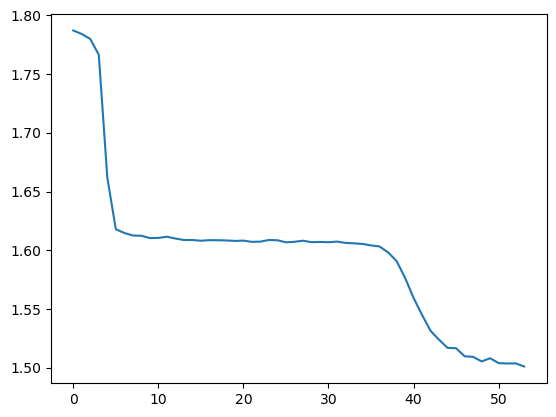

In [198]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss)), epoch_loss)

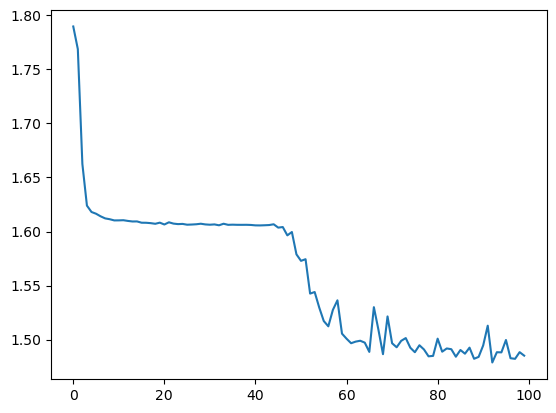

In [39]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss)), epoch_loss)

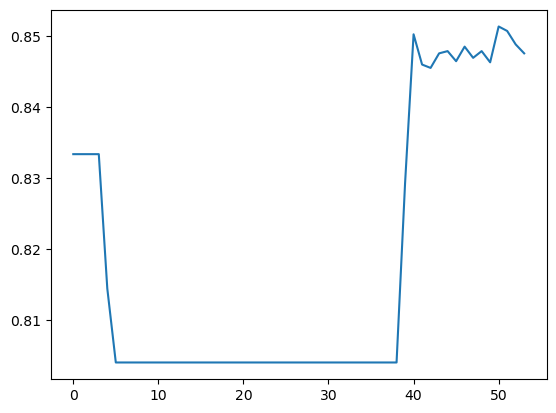

In [199]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_acc)), epoch_acc)

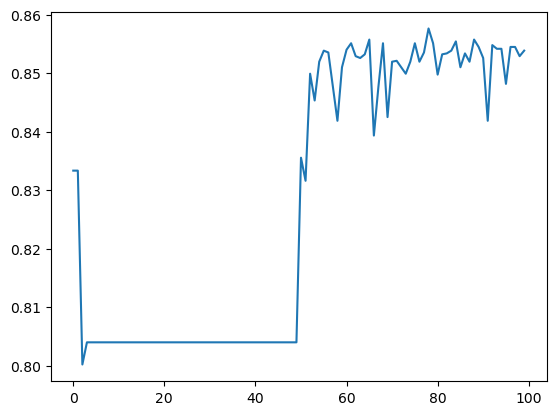

In [40]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_acc)), epoch_acc)

In [200]:
model.eval()
true_labels = []
pred_labels = []
for i,x in tqdm(enumerate(X_valid)):
    x_lens = torch.Tensor([X_valid_lens.iloc[i]]).to(device)
    x = torch.from_numpy(np.expand_dims(X_valid.iloc[i],axis=0)).to(torch.float32).to(device)
    Y_hat = model(x, x_lens)
    batch_output_jj = torch.from_numpy(Y_valid.iloc[i]).to(device)

    pred_labels += list(np.where(Y_hat.detach().numpy().round() == 1)[1])
    true_labels += list(np.where(batch_output_jj.detach().numpy() == 1)[0])

0it [00:00, ?it/s]

In [179]:
np.unique(pred_labels)

array([0, 2])

In [180]:
np.unique(true_labels)

array([0, 1, 2, 3, 5])

In [201]:
from sklearn.metrics import classification_report
print(classificatison_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.48      0.91      0.63       133
           1       0.00      0.00      0.00        57
           2       0.54      0.46      0.50       113
           3       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        14

    accuracy                           0.50       348
   macro avg       0.20      0.27      0.23       348
weighted avg       0.36      0.50      0.40       348



/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/labadmin/anaconda3/envs/bonn17/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [129]:
from sklearn.svm import SVC

In [183]:
input = pad_batch_online(X_train_lens, X_train, style="zero").reshape((X_train.shape[0],-1))

In [184]:
input_valid = pad_batch_online(X_valid_lens, X_valid, style="zero").reshape((X_valid.shape[0],-1))

In [185]:
model = SVC(kernel='rbf')
model.fit(input, Y_train.apply(lambda x: np.where(x==1)[0][0]))

SVC()

In [186]:
Y_valid.apply(lambda x: np.where(x==1)[0][0]).unique()

array([2, 0, 3, 1, 5])

In [187]:
Y_pred = model.predict(input_valid)

In [190]:
np.unique(Y_pred)

array([0, 1, 2, 3, 5])

In [191]:
print(classification_report(Y_valid.apply(lambda x: np.where(x==1)[0][0]), Y_pred, ))

              precision    recall  f1-score   support

           0       0.56      0.87      0.68       133
           1       0.84      0.28      0.42        57
           2       0.63      0.65      0.64       113
           3       1.00      0.19      0.32        31
           5       1.00      0.07      0.13        14

    accuracy                           0.61       348
   macro avg       0.81      0.41      0.44       348
weighted avg       0.69      0.61      0.57       348

